<br>Le notebook présente les analyses de données scrappées sur le site https://fr.openfoodfacts.org/ <br/> L'organisation du notebook est la suivante: 

1. Scraping du site Openfoodfacts
2. Nettoyage du dataset en vue des analyses des données
<br/> 2.1. Transformation en variables numériques de certaines colonnes et nettoyage des variables catégorielles
<br/> 2.2. Calcul du nombre de pays de ventes et du nombre d'additifs pour chaque produit.
3. Analyses
<br/> 3.1.  Distribution du nombre de produits par catégorie Nutri Score, Nova et Eco score.(100 possibilités)
<br/> 3.2. Liste des produits ayant “gluten free” optimaux (Nutri score A, Nova 1 et Ecoscore A
<br/> 3.3. Nombre de produit dont le ratio sucre/produit est supérieur à 0.6
<br/> 3.4. Liste des produits dont le nombre de calories pour 100g est supérieur à 500.
<br/> 3.5. Liste des produits contenant de l’huile de palme, vendu en France et en Belgique
<br/> 3.6. Distribution des produits par nombre de pays de vente
<br/> 3.7. Est-ce que tous les produits du site sont vendus en France ?
<br/> 3.8. L'écoscore est-il sensible au nombre de pays de vente?
<br/> 3.9. Les produits végétariens, végétaliens sont ils dans l'ensemble très transformés ?
<br/> 3.10. Quels sont les 20 produits végétariens contenant le plus d'additifs? 
4. Un modèle de machine learning pour prédire le nutriscore d'un produit.


# 1. Scraping du site Openfoodfacts


In [1]:
import opfoodfact  

In [3]:
#data=opfoodfact.scrap_opfoodfacts(800)  

temps d'exécution:  42538.536375284195  sec


Temps d'exécution : 42538 secondes soit 11.8 heures pour 800 pages scrapées, autrement dit 53 secondes par page. <br/> Les données sont scrapées à partir de la 2e page du site (erreur sur un début de boucle qui a été corrigée dans le programme openfoodfact.py)

In [17]:
data.shape  #80 000 produits 

(80000, 31)

Les 26 champs demandés sur le sujet on été récupéré. Nous avons scrappé en plus :
* Les vitamines et minéraux ajoutés
* Les étiquettes vertes rouges ou oranges correspondant auc mentions huile de palme/végétarien/végétalien.

In [337]:
#data.to_csv('data.csv',index=False,sep=';')  #export du dataset en un fichier csv

# 2. Nettoyage du dataset en vue des analyses de données

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#options d'affichage des dataframe
pd.set_option("display.max_columns", 36)
pd.set_option("display.max_colwidth", 100)


In [14]:
#Récupération du dataset
data=pd.read_csv('data.csv',sep=';')  

In [15]:
data.shape

(80000, 31)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   nom                                             80000 non-null  object
 1   URL                                             80000 non-null  object
 2   code bar                                        80000 non-null  object
 3   nutrtri-score                                   80000 non-null  object
 4   nova                                            80000 non-null  object
 5   ecoscore                                        80000 non-null  object
 6   quantite                                        79998 non-null  object
 7   conditionnement                                 80000 non-null  object
 8   marques                                         80000 non-null  object
 9   categorie                                       80

In [17]:
# correction des noms de certaines colonnes
data.rename(columns={'nutrtri-score' : 'nutriscore','libellés vert':'libellés verts','libellés orange':'libellés oranges',\
                    'libellés rouge':'libellés rouges','énergie en kj':'énergie en kj pour 100g',\
                    'énergie en kcal':'énergie en kcal pour 100g'},inplace=True) 

In [18]:
data.columns

Index(['nom', 'URL', 'code bar', 'nutriscore', 'nova', 'ecoscore', 'quantite',
       'conditionnement', 'marques', 'categorie',
       'label,certifications,récompenses', 'origine', 'lieu de fabrication',
       'code de traçabilité', 'lien vers la page du produit', 'magasins',
       'pays de vente', 'additifs', 'ingrédients issus de l'huile de palme',
       'vitamines ajoutées', 'minéraux ajoutés',
       'matières grasses/lipides pour 100g', 'acides gras saturés pour 100g',
       'sucres pour 100g', 'sel pour 100g',
       'catégories aux repères nutritionels similaires',
       'énergie en kj pour 100g', 'énergie en kcal pour 100g',
       'libellés verts', 'libellés oranges', 'libellés rouges'],
      dtype='object')

### 2. 1. Transformation en variables numériques de certaines variables et nettoyage des variables catégorielles

In [19]:
def clean(var):
    y=var.strip().strip(',').replace("kcal","").replace("g","").replace("kj","").replace('\xa0','').replace('?','').replace(' ','')
    return y

def tofloat(x):
    try:
        y=float(x)
    except:
        y=np.nan
    return y

# on transforme les colonnes donnant les quantités pour 100g de matières grasses/lipides,sucres,sel et acides gras saturés en appliquant 
#les deux fonctions précédents. 
for i in [21,22,23,24,26,27]:
    col=data.columns[i]
    data[col]=data[col].transform(clean).transform(tofloat)

# on nettoie les colonnes de type object (on supprime la virgule et les espaces à la fin du texte)
for i in range(len(data.columns)):
    col=data.columns[i]
    if data[col].dtypes==object : 
        data[col]=data[col].str.strip(' ')
        data[col]=data[col].str.strip(',')

### 2.2. Calcul du nombre de pays de ventes et du nombre d'additifs pour chaque produit.

On remarque que certains pays peuvent être présents plusieurs fois, en plusieurs langues. On tente un nettoyage de la colonne pays de vente.  

In [20]:
data['pays de vente'][33]

'France, Maroc, Espagne, Suisse, en:Alemania, en:Egipto, en:Francia, en:Suiza'

In [21]:
data.iloc[33,1]

'https://fr.openfoodfacts.org//produit/3161711001971/caprice-des-dieux'

In [23]:
liste.sort()


In [26]:
liste

['(100 produits)',
 'Afrique du Sud',
 'Allemagne',
 'Arabie saoudite',
 'Belgien',
 'België',
 'Bélgica',
 'DOM TOM',
 'Deutschland',
 'Dom-tom',
 'Espagne',
 'France',
 'Francia',
 'Frankreich',
 'Frankrijk',
 'Gabon',
 'Galmudug',
 'Ghana',
 'Grèce',
 'Guadalupe',
 'Guadeloupe',
 'Guinée',
 'Guyane',
 'Géorgie',
 'Hong Kong',
 'Hongrie',
 'Inde',
 'Irak',
 'Iran',
 'Irlande',
 'Israël',
 'Italie',
 'Japon',
 'Jersey',
 'Jordanie',
 'Kazakhstan',
 'Koweït',
 'La Réunion',
 'Liban',
 'Libye',
 'Luxembourg',
 'Macao',
 'Madagascar',
 'Malaisie',
 'Malte',
 'Maroc',
 'Marokko',
 'Marruecos',
 'Martinique',
 'Maurice',
 'Mauritanie',
 'Mayotte',
 'Mexique',
 'Monaco',
 'Niederlande',
 'Nigeria',
 'Norvège',
 'Nouvelle-Calédonie',
 'Nouvelle-Zélande',
 'Panama',
 'Pays-Bas',
 'Philippines',
 'Pologne',
 'Polonia',
 'Polska',
 'Polynésie française',
 'Portugal',
 'Qatar',
 'Roumanie',
 'Royaume-Uni',
 'Russie',
 'Saint-Martin',
 'Saint-Pierre-et-Miquelon',
 'Schweiz',
 'Serbie',
 'Singapou

In [76]:
#Grâce à la liste précédente,on nettoie la colonne pays de vente:

In [77]:
data['pays de vente']=data['pays de vente'].str.replace('..:','')
data['pays de vente']=data['pays de vente'].str.replace('(é|è|É)','e')
data['pays de vente']=data['pays de vente'].str.replace('-','',regex=False)
data['pays de vente']=data['pays de vente'].str.replace('Arabia Saudita','Arabie saoudite',regex=False)
data['pays de vente']=data['pays de vente'].str.replace('Czarnogóra','Montenegro')


In [78]:
import time
import re
liste=[]
start=time.time()

for i, var in enumerate(data['pays de vente']):
    pays=var.split(',')
    
    for elt in pays:
        elt=elt.strip()
        
        if re.search(r'(Paysan|Breton|land|en|100|Deutsch|English|Español|Loire|gourmand)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'')
            elt=''
        
        if re.search(r'(Duitsland|Germany|Alema|Allema)',elt,re.IGNORECASE):
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Allemagne')
            elt='Allemagne'
            

        if re.search(r'^Austr',elt,re.IGNORECASE):
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Australie')
            elt='Australie'
            
            
        if re.search(r'(^Belgi|Βέλγιο)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Belgique')
            elt='Belgique'
            
        elif re.search(r'^Boliv',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Bolivie')
            elt='Bolivie'
        
        elif re.search(r'^Bosni',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Bosnie Herzegovine')
            elt='Bosnie Herzegovine'
        
        elif re.search(r'Br',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Bresil')
            elt='Bresil'
            
        elif re.search(r'^Bulgar',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Bulgarie')
            elt='Bulgarie'
        elif re.search(r'^Cambodia',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Cambodge')
            elt='Cambodge'
        elif re.search(r'^Canada',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Canada')
            elt='Canada'
        elif re.search(r'^Chil',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Chili')
            elt='Chili'
        elif re.search(r'^Chin',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Chine')
            elt='Chine'
        elif re.search(r'(^Chypr|Cyprus)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Chypre')
            elt='Chypre'
        elif re.search(r'(^Croat|Chorwacja)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Croatie')
            elt='Croatie'
        elif re.search(r'(^Czech|Tcheque)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Tchéquie')
            elt='Tchéquie'
        elif re.search(r'(^D.n.m|^D.nm)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Danemark')
            elt='Danemark'
        elif re.search(r'^DOM',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'DOM-TOM')
            elt='DOM-TOM'
        elif re.search(r'^Esp',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Espagne')
            elt='Espagne'
        elif re.search(r'(^Fran.|Γαλλία)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'France')
            elt='France'
        elif re.search(r'^Guad',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Guadeloupe')
            elt='Guadeloupe'
        elif re.search(r'^Ital',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Italie')
            elt='Italie'
        elif re.search(r'reunion',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'La Reunion')
            elt='La Reunion'
        elif re.search(r'^(Luks|Lux)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Luxembourg')
            elt='Luxembourg'
        elif re.search(r'(^Maro|Marruecos|Maroc)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Maroc')
            elt='Maroc'
            
        elif re.search(r'Caledoni',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Nouvelle Caledonie')
            elt='Nouvelle Caledonie'
        elif re.search(r'Pays',elt,re.IGNORECASE) and re.search(r'Bas',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Pays-Bas')
            elt='Pays-Bas'
        
        elif re.search(r'(Pol|Países Bajos|Polen)',elt,re.IGNORECASE) and not re.search(r'Poly',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Pologne')
            elt='Pologne'
            
        elif re.search(r'Polynesie',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Polynesie française')
            elt='Polynesie française'
        elif re.search(r'royaume',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Polynesie française')
            elt='Polynesie française'
        elif re.search(r'(royaume|united|Vereinigtes|reino)',elt,re.IGNORECASE) and re.search(r'(kingdom|Königreich|unido)',elt,re.IGNORECASE) : 
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Royaume-Unis')
            elt='Royaume-Unis'
        
        elif re.search(r'Rum',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Roumanie')
            elt='Roumanie'
        
        elif re.search(r'(^Grec|Σερβία|serb)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Serbie')
            elt='Serbie'
        elif re.search(r'(Schweiz|^Sui|Szwajcaria|Ελβετία)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Suisse')
            elt='Suisse'
        
        elif re.search(r'(^spa|Hiszpania)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Espagne')
            elt='Espagne'
        elif re.search(r'ungar',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Hongrie')
            elt='Hongrie'
            
        elif re.search(r'(^Grec|Ελλάδα)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Grèce')
            elt='Grèce'
        elif re.search(r'(Estados Unidos|Etatsunis)',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Etats-Unis')
            elt='Etats-Unis'
        elif re.search(r'europe',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Europe')
            elt='Europe'
        elif re.search(r'Wybrzeże Kości Słoniowej',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Cote d\'Ivoire')
            elt='Cote d\'Ivoire'
        elif re.search(r'^sue',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Suede')
            elt='Suede'
        elif re.search(r'^eg',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Egypte')
            elt='Egypte'
        elif re.search(r'^azerba',elt,re.IGNORECASE) :
            data.loc[i,'pays de vente']=data.loc[i,'pays de vente'].replace(elt,'Azerbaidjan')
            elt='Azerbaidjan'

        if elt not in liste:
            liste.append(elt)

print(time.time()-start)

364.9883096218109


Création des colonnes "nombre de pays de vente" et "nombre d'additifs"

In [27]:
data['pays de vente'][33]

'France, Maroc, Espagne, Suisse, en:Alemania, en:Egipto, en:Francia, en:Suiza'

In [28]:
#supression des doublons
def suppr_dbl(x):
    l=x.split(',')
    l=[x.strip() for x in l]
    lu=np.unique(l)
    y=", ".join(lu)
    return y
data['pays de vente']=data['pays de vente'].apply(suppr_dbl)

In [29]:
data['pays de vente'][33]

'Espagne, France, Maroc, Suisse, en:Alemania, en:Egipto, en:Francia, en:Suiza'

In [30]:
#nombre de pays de vente :
def nbpays(x) : 
    """détermine le nombre de pays de ventes d'un produit
    entrée : les pays de vente séparés par des virgules
    sorties : nombre de pays de vente en type str dans les chasses 1, 2,3 ou 4+ """
    if x=="xxx" :
        return "xxx"
    elif x=="":
        return '0'
    elif len(x.split(','))>=4:
        return '4+'
    else:
        return str(len(x.split(',')))

def nbadd(x):
    """détermine le nombre d'additifs d'un produit
    entrée : les additifs séparés par des virgules
    sorties : nombre d'additifs en numeric """
    if x=="xxx":
        return np.nan
    elif x=="":
        return 0
    else:
        return len(x.split(','))


In [31]:
data['nb_pays_vente']=data['pays de vente'].apply(nbpays)
data['nb_additifs']=data['additifs'].apply(nbadd)

In [109]:
#data.to_csv('data_cleaned.csv',sep=';')

# 3.  Analyses

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#options d'affichage des dataframe
pd.set_option("display.max_columns", 36)
pd.set_option("display.max_colwidth", 100)


In [33]:
data=pd.read_csv('data_cleaned.csv',sep=';')

In [112]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'nom', 'URL', 'code bar', 'nutriscore',
       'nova', 'ecoscore', 'quantite', 'conditionnement', 'marques',
       'categorie', 'label,certifications,récompenses', 'origine',
       'lieu de fabrication', 'code de traçabilité',
       'lien vers la page du produit', 'magasins', 'pays de vente', 'additifs',
       'ingrédients issus de l'huile de palme', 'vitamines ajoutées',
       'minéraux ajoutés', 'matières grasses/lipides pour 100g',
       'acides gras saturés pour 100g', 'sucres pour 100g', 'sel pour 100g',
       'catégories aux repères nutritionels similaires',
       'énergie en kj pour 100g', 'énergie en kcal pour 100g',
       'libellés verts', 'libellés oranges', 'libellés rouges',
       'nb_pays_vente', 'nb_additifs', 'huile de palme'],
      dtype='object')

### 3.1. Distribution du nombre de produits par catégorie Nutri Score, Nova et Eco score.( 100 possibilités)

In [113]:
#effectifs par nutriscore, nova, ecoscore
pd.crosstab(data['nutriscore'], [data['nova'], data['ecoscore']])
 

nova          1                               2                            3  \
ecoscore      A     B    C    D    E   xxx    A    B    C    D    E xxx    A   
nutriscore                                                                     
A           508  1310  481  137  120  1009    0    1    1    3    0   0  726   
B            24   307  199  174   59   187    0    1    0    0    0   2  274   
C            40   163  361  406   52   152    2   39  135   90    0  26  240   
D            10    65  103   53   24    85   78  123   36   47   13  34  134   
E             1    10   34   13    3    48    1    0   76  135  130  55   28   
xxx         231   332   67   80  127   336  238  285   12   10    6   2   30   

nova                                     4                                xxx  \
ecoscore       B    C     D    E  xxx    A     B     C     D     E   xxx    A   
nutriscore                                                                      
A           1158  234    95   45  660  528  1179   284   217   128  1050  185   
B            606  187   291  187  553  481  1203   703   590   381  1498   49   
C            890  335   411  134  542  407  2017  1715   963   287  2034   68   
D           1045  931  1032  288  453  236  1949  2138  1872   854  2058   60   
E            211  340   374   86  197   52   514  1302  1889  1126  1961   11   
xxx          180  250    66   10  189  473   482   332   218    67  3225  158   

nova                                  
ecoscore      B    C    D    E   xxx  
nutriscore                            
A           739  205  188   87   639  
B           399  251  312  147   656  
C           545  497  661  166   686  
D           633  535  689  305   837  
E           135  336  343  215   675  
xxx         746  298  207  172  8448

In [114]:
dh=pd.crosstab(data['nutriscore'], [data['nova'], data['ecoscore']],normalize=True)
dh=np.round(dh,4)*100  #obtenir les proportions en %

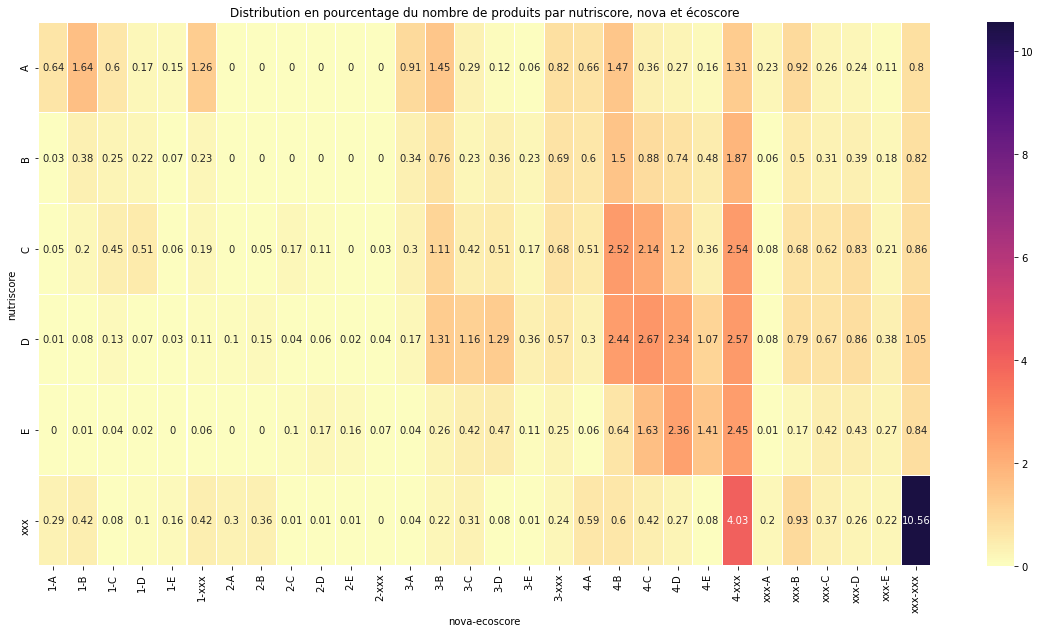

In [115]:
dh=pd.crosstab(data['nutriscore'], [data['nova'], data['ecoscore']],normalize=True)
dh=np.round(dh,4)*100  #obtenir les proportions en %
# visualisation avec heatmap
plt.figure(figsize=(20,10))
ax=plt.axes()
sns.heatmap(dh,cmap='magma_r',linewidths=0.01,xticklabels=1,annot=True,fmt='g',center=6)
ax.set_title('Distribution en pourcentage du nombre de produits par nutriscore, nova et écoscore')
plt.show()

10,6 % des produits du dataset n'ont aucune indication nutriscore, nova ni eco-score. <br/>
On remarque particulièrement la faible proportion de produits qui ont un nova à 2, ainsi que la plus forte présence de produits de nova 4 avec un nutriscore D ou E.   

### 3.2. Liste des produits ayant “gluten free” optimaux (Nutri score A, Nova 1 et Ecoscore A)

In [116]:
dgf_op=data[(data['nom'].str.contains('(sans gluten|glutenfree|gluten free)',flags=re.IGNORECASE)) &\
    (data['nova']=='1') & (data['nutriscore']=='A') & (data['ecoscore']=='A')]
dgf_op

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Unnamed: 0,Unnamed: 0.1,nom,URL,code bar,nutriscore,nova,ecoscore,quantite,conditionnement,marques,categorie,"label,certifications,récompenses",origine,lieu de fabrication,code de traçabilité,lien vers la page du produit,magasins,pays de vente,additifs,ingrédients issus de l'huile de palme,vitamines ajoutées,minéraux ajoutés,matières grasses/lipides pour 100g,acides gras saturés pour 100g,sucres pour 100g,sel pour 100g,catégories aux repères nutritionels similaires,énergie en kj pour 100g,énergie en kcal pour 100g,libellés verts,libellés oranges,libellés rouges,nb_pays_vente,nb_additifs,huile de palme
1569,1569,1569,Tartines craquantes bio au sarrasin sans gluten - Le Pain des Fleurs - 150 g,https://fr.openfoodfacts.org//produit/3380380046940/tartines-craquantes-bio-au-sarrasin-sans-glu...,3380380046940,A,1,A,150 g,Carton,Le Pain des Fleurs,"Aliments et boissons à base de végétaux, Aliments d'origine végétale, Céréales et pommes de terr...","Peu ou pas de sel, Peu ou pas de sucre, Bio, Végétarien, Sans gluten, Végétalien, Fabriqué en Fr...",xxx,xxx,xxx,https://fr.openfoodfacts.org/eco-score-l-impact-environnemental-des-produits-alimentaires,xxx,"Belgique, France",xxx,xxx,xxx,xxx,2.7,0.6,1.7,0.0,Tartines craquantes,1642.0,388.0,"Sans huile de palme, Végétalien, Végétarien",xxx,xxx,2,NaN,xxx


Nous ne trouvons qu'un seul produit gluten free "optimal". Nous décidons de faire une heatmap particulière pour les produits sans gluten. 

In [117]:
#ensemble des produits gluten free
dgf=data[data['nom'].str.contains('(sans gluten|glutenfree|gluten free)',flags=re.IGNORECASE)]

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [118]:
dgf.shape  #présence de 349 produits dans notre dataset

(349, 36)

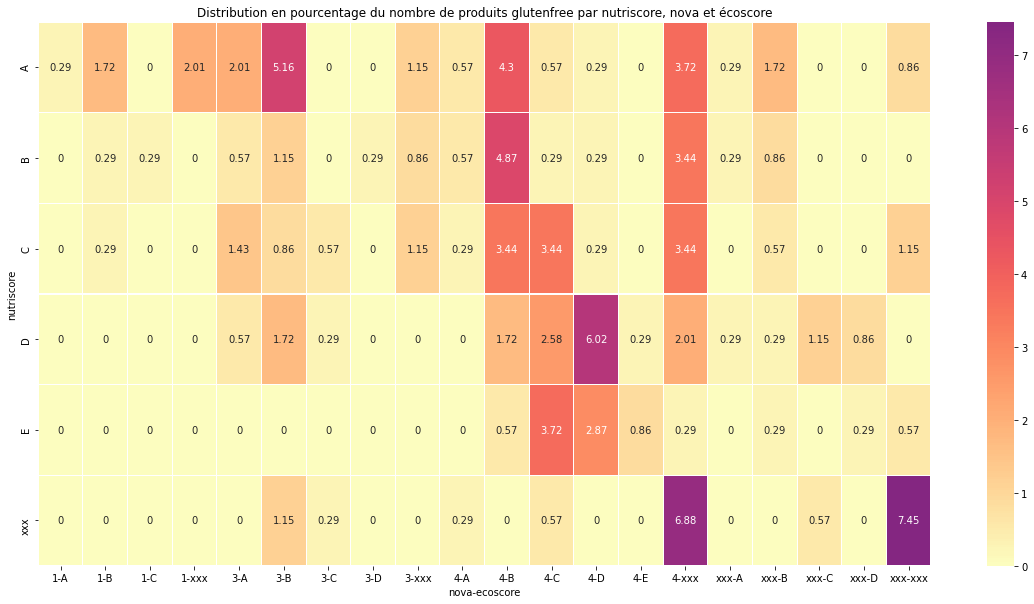

In [119]:
dh=pd.crosstab(dgf['nutriscore'], [dgf['nova'], dgf['ecoscore']],normalize=True)
dh=np.round(dh,4)*100  #obtenir les proportions en %
# visualisation avec heatmap
plt.figure(figsize=(20,10))
ax=plt.axes()
sns.heatmap(dh,cmap='magma_r',linewidths=0.01,xticklabels=1,annot=True,fmt='g',center=6)
ax.set_title('Distribution en pourcentage du nombre de produits glutenfree par nutriscore, nova et écoscore')
plt.show()

L'une des plus large sous classe des produits gluten free a pour nutriscore D, nova 4 et ecoscore D (6.02 %)

### 3.3 Nombre de produit dont le ratio sucre/produit est supérieur à 0.6


In [120]:
data[data['sucres pour 100g']>60].shape

(1624, 36)

In [121]:
data[data['sucres pour 100g']>60].sort_values(by='sucres pour 100g',ascending=False).loc[:,['nom','URL','sucres pour 100g']].head(10)

,nom,URL,sucres pour 100g
20849,Dulce de leche Estilo Colonial - La Serenísima - 400 g,https://fr.openfoodfacts.org//produit/7790742140609/dulce-de-leche-estilo-colonial-la-serenisima,275.0
8794,Poudre de chocolat - Nestlé - 800 g,https://fr.openfoodfacts.org//produit/7613036184359/poudre-de-chocolat-nestle,146.0
40024,Koa & Choc 7 vitamines - Rik & Rok - 400 g,https://fr.openfoodfacts.org//produit/3254560039940/koa-choc-7-vitamines-rik-rok,135.0
40051,Leader quick - Leader Price - 1 kg,https://fr.openfoodfacts.org//produit/3263850776212/leader-quick-leader-price,125.0
8252,Grand arôme - Poulain - 400g,https://fr.openfoodfacts.org//produit/10662564/grand-arome-poulain,120.0
20783,Sirop d'agave pur - Allos - 500 ml,https://fr.openfoodfacts.org//produit/4016249015732/sirop-d-agave-pur-allos,104.0
31700,Sucre Poudre - Béghin Say - 500 g,https://fr.openfoodfacts.org//produit/3174660000902/sucre-poudre-beghin-say,100.0
22103,Erstein morceau boite 1kg - gamme courants - 1000 g,https://fr.openfoodfacts.org//produit/3071900001111/erstein-morceau-boite-1kg-gamme-courants,100.0
64353,Sucre de betterave bio - AF - 750 g,https://fr.openfoodfacts.org//produit/3268740100016/sucre-de-betterave-bio-af,100.0
9111,Sucre blond de canne - CARREFOUR BIO - 500 g,https://fr.openfoodfacts.org//produit/3270190191155/sucre-blond-de-canne-carrefour-bio,100.0


certains produits ont un taux >100, je suppose qu'il s'agit d'une erreur de conversion/report.

### 3. 4. Liste des produits dont le nombre de calories pour 100g est supérieur à 500.

In [122]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'nom', 'URL', 'code bar', 'nutriscore',
       'nova', 'ecoscore', 'quantite', 'conditionnement', 'marques',
       'categorie', 'label,certifications,récompenses', 'origine',
       'lieu de fabrication', 'code de traçabilité',
       'lien vers la page du produit', 'magasins', 'pays de vente', 'additifs',
       'ingrédients issus de l'huile de palme', 'vitamines ajoutées',
       'minéraux ajoutés', 'matières grasses/lipides pour 100g',
       'acides gras saturés pour 100g', 'sucres pour 100g', 'sel pour 100g',
       'catégories aux repères nutritionels similaires',
       'énergie en kj pour 100g', 'énergie en kcal pour 100g',
       'libellés verts', 'libellés oranges', 'libellés rouges',
       'nb_pays_vente', 'nb_additifs', 'huile de palme'],
      dtype='object')

In [123]:
data[data['énergie en kcal pour 100g']>500].sort_values(by='énergie en kcal pour 100g',ascending=False).loc[:,['nom','URL','énergie en kcal pour 100g']]

,nom,URL,énergie en kcal pour 100g
4067,Chocolat noir Amande et écorces d'orange - J.D. Gross - 125g,https://fr.openfoodfacts.org//produit/20936600/chocolat-noir-amande-et-ecorces-d-orange-j-d-gross,4580.0000
3999,Petit St Michel Bio au bon beurre - 144g,https://fr.openfoodfacts.org//produit/3178530419979/petit-st-michel-bio-au-bon-beurre,3720.0000
55125,Psyllium Blond Bio - 150G - Uberti - 150 g,https://fr.openfoodfacts.org//produit/3760048990790/psyllium-blond-bio-150g-uberti,2810.0000
21132,Mayonesa - Kania - 500 ml,https://fr.openfoodfacts.org//produit/20578992/mayonesa-kania,2569.0000
48494,Nu+cao coconut cinnamon - nucao - 40g,https://fr.openfoodfacts.org//produit/4260500650013/nu-cao-coconut-cinnamon-nucao,2558.0000
...,...,...,...
55771,Kessel Chips - Pulled Beef flavour - Snack Day - 150 g,https://fr.openfoodfacts.org//produit/4056489141136/kessel-chips-pulled-beef-flavour-snack-day,501.0000
55836,Crusti Croc Kessel Chips Sweet Chili - 150,https://fr.openfoodfacts.org//produit/20768034/crusti-croc-kessel-chips-sweet-chili,501.0000
3182,Nos tartinettes à croquer - jardin Bio - 138g,https://fr.openfoodfacts.org//produit/3456300009880/nos-tartinettes-a-croquer-jardin-bio,501.0000
9940,Granola low sugar - Lizi's - 500g,https://fr.openfoodfacts.org//produit/5060092030687/granola-low-sugar-lizi-s,501.0000


### 3.5. Liste des produits contenant de l’huile de palme, vendus en France et en Belgique

In [124]:
def palm(x):
    if re.search('palm',x,re.IGNORECASE):
        return True
    else:
        return 'xxx'

data['huile de palme']=data['libellés rouges'].apply(palm) #True si le produit porte l'étiquette "présence d'huile de palme","xxx" sinon


On compte 4819 produits contenant de l'huile de palme vendus en France ou en Belgique: 

In [125]:
#les noms des pays ont déjà été nettoyés dans la partie 2.
df=data[(data['pays de vente'].str.contains('(France|belgique)',case=False)) & (data['huile de palme']==True)].loc[:,['nom','URL']]
print(df.shape)
df.head(20)

(4819, 2)


C:\Users\celine\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,nom,URL
0,Pain grillé de campagne Blé complet - Pelletier - 500 g e,https://fr.openfoodfacts.org//produit/3017760542890/pain-grille-de-campagne-ble-complet-pelletier
5,bn chocolat - 10,https://fr.openfoodfacts.org//produit/3061990141354/bn-chocolat
8,Thé - Biscuits - Lu thé - 350 g ℮,https://fr.openfoodfacts.org//produit/7622210476296/the-biscuits-lu-the
24,Granola Gros éclats de Chocolat - LU - 276 g,https://fr.openfoodfacts.org//produit/7622300689124/granola-gros-eclats-de-chocolat-lu
26,Krisprolls - 425 g,https://fr.openfoodfacts.org//produit/7311070032611/krisprolls
27,Kinder bueno gaufrettes enrobees de chocolat 2 barres - 43 g,https://fr.openfoodfacts.org//produit/8000500037560/kinder-bueno-gaufrettes-enrobees-de-chocolat...
29,"Biscotte Fibres+ - Heudebert - 280g, 2 sachets de 16 biscottes",https://fr.openfoodfacts.org//produit/3017760363990/biscotte-fibres-heudebert
43,Extra chocolat au lait - Kellogg’s - 500g,https://fr.openfoodfacts.org//produit/5050083516313/extra-chocolat-au-lait-kellogg-s
73,Nutella - Ferrero - 350 g,https://fr.openfoodfacts.org//produit/80177173/nutella-ferrero
75,Spéculoos à tartiner - Lotus - 400g,https://fr.openfoodfacts.org//produit/5410126006957/speculoos-a-tartiner-lotus


Il s'agit essentiellement de biscuits et gâteaux.
<br/> Question: 
est ce que l'on compte sur openfoodfacts plus de produits contenant de l'huile de palme en vendus France ou en Belgique ?

### 3.6 Distribution des produits par nombre de pays de vente

In [126]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'nom', 'URL', 'code bar', 'nutriscore',
       'nova', 'ecoscore', 'quantite', 'conditionnement', 'marques',
       'categorie', 'label,certifications,récompenses', 'origine',
       'lieu de fabrication', 'code de traçabilité',
       'lien vers la page du produit', 'magasins', 'pays de vente', 'additifs',
       'ingrédients issus de l'huile de palme', 'vitamines ajoutées',
       'minéraux ajoutés', 'matières grasses/lipides pour 100g',
       'acides gras saturés pour 100g', 'sucres pour 100g', 'sel pour 100g',
       'catégories aux repères nutritionels similaires',
       'énergie en kj pour 100g', 'énergie en kcal pour 100g',
       'libellés verts', 'libellés oranges', 'libellés rouges',
       'nb_pays_vente', 'nb_additifs', 'huile de palme'],
      dtype='object')

In [130]:
print(data['nb_pays_vente'].value_counts())
print(data['nb_pays_vente'].value_counts(normalize=True))

1      58666
2      15949
3       3661
4+      1723
xxx        1
Name: nb_pays_vente, dtype: int64
1      0.733325
2      0.199362
3      0.045762
4+     0.021538
xxx    0.000013
Name: nb_pays_vente, dtype: float64


73 % des produits ont un seul pays de vente

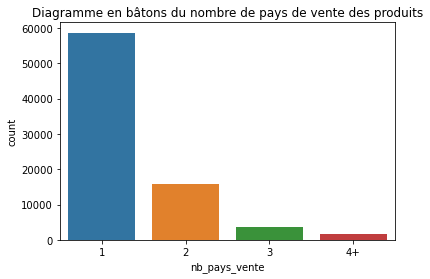

In [132]:
sns.countplot(data=data,x='nb_pays_vente',order=['1','2','3','4+'])
plt.title('Diagramme en bâtons du nombre de pays de vente des produits')
plt.show()

### 3.7 Est-ce que tous les produits du site sont vendus en France ?

In [137]:
data[data['pays de vente'].str.contains('France',case=False)].shape[0]

79999

In [139]:
data[data['pays de vente'].str.contains('Allemagne',case=False)].shape[0]

4390

In [141]:
data[data['pays de vente'].str.contains('Grèce',case=False)].shape[0]

1

Dans notre dataset, la (quasi)totalité des produits sont vendus en France.
<br/>Openfoodfacts est un projet collaboratif né en France où l'on peut répertorier des produits du monde entier  (https://fr.openfoodfacts.org/decouvrir)
<br/> On peut penser qu'openfoodfacts n'est pas très connu à l'internationale et que ce sont essentiellement des bénévoles Français qui ont rempli les renseignements des produits.

### 3.8 L'écoscore est-il sensible au nombre de pays de vente?

In [142]:
a=pd.crosstab(data['ecoscore'],data['nb_pays_vente'])

In [143]:
b=a.apply(lambda x: x*100/sum(x), axis=1)

In [144]:
b

nb_pays_vente,1,2,3,4+,xxx
ecoscore,,,,,
A,80.428599,13.901005,3.356723,2.313673,0.000000
B,74.726357,18.642497,4.331963,2.299183,0.000000
C,71.320084,20.487963,5.509775,2.682178,0.000000
D,72.393222,20.776414,4.763963,2.066402,0.000000
E,73.270742,18.528454,5.115923,3.084882,0.000000
xxx,72.435240,21.525250,4.367954,1.668021,0.003534


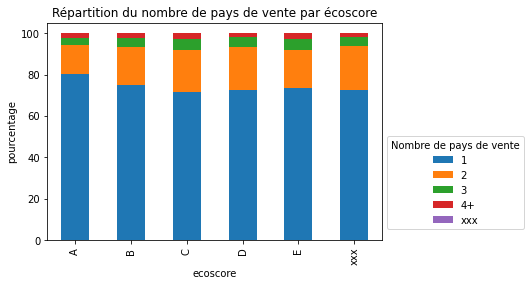

In [145]:
b.plot(kind='bar', stacked=True,title='Répartition du nombre de pays de vente par écoscore').legend(bbox_to_anchor=(1, 0.5))
plt.ylabel('pourcentage')
plt.legend(bbox_to_anchor=(1, 0.5),title='Nombre de pays de vente')
plt.show()

80% des produits en écoscore A sont vendus dans un seul pays de vente, 74 % pour l'ecoscore B, 71% pour le C et 73% pour le E. 
Remarque : L'écoscore semble légèrement sensible au nombre de pays de vente. 

### 3.9 Les produits végétariens, végétaliens sont ils dans l'ensemble très transformés ?

In [146]:
import re

def vegetar(x):
    if re.search('v.g.tarien',x,re.IGNORECASE):
        return True
    else:
        return 'xxx'

def vegetal(x):
    if re.search('v.g.talien',x,re.IGNORECASE):
        return True
    else:
        return 'xxx'


In [148]:
data['vegetarien']=data['libellés verts'].apply(vegetar) #True si le produit porte le libellé 'est végétarien', xxx sinon
data['vegetalien']=data['libellés verts'].apply(vegetal) # True si le produit porte le libellé 'est végétalien', xxx sinon
data['nvegetarien']=data['libellés rouges'].apply(vegetar) #True si le produit porte le libellé 'est végétarien' ,  xxx sinon
data['nvegetalien']=data['libellés rouges'].apply(vegetal) # True si le produit porte le libellé 'n'est pas végétalien', xxx sinon


In [149]:
#on créée respectivement des datasets des produits végétaliens, végétariens, non végétariens, non végétaliens, avec huile de palme
data_v=data[data['vegetarien']==True]
data_vl=data[data['vegetalien']==True]
data_nv=data[data['nvegetarien']==True]
data_nvl=data[data['nvegetalien']==True]
data_p=data[data['huile de palme']==True]

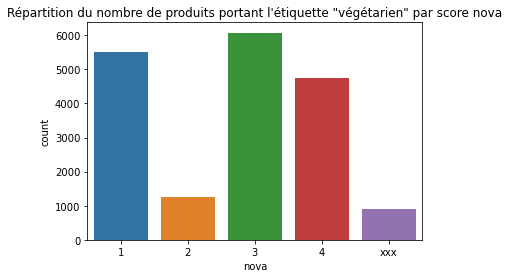

In [150]:
sns.countplot(data=data_v,x='nova',order=['1','2','3','4','xxx'])
plt.title('Répartition du nombre de produits portant l\'étiquette "végétarien" par score nova')
plt.show()

Parmi les produits végétariens, on compte davatage de produits nova 3 ou 4 (transformés et ultra-transformés) que de nova 1, même si la quantité de produits végétariens nova 1 reste importante. Les produits végétaliens, eux sont dans l'ensemble moins transformés:

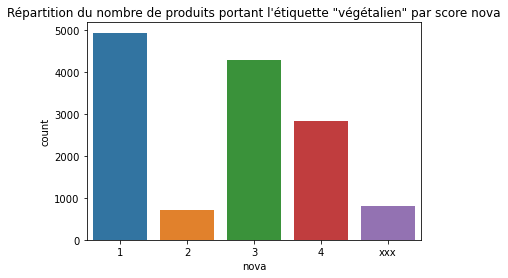

In [151]:
sns.countplot(data=data_vl,x='nova',order=['1','2','3','4','xxx'])
plt.title('Répartition du nombre de produits portant l\'étiquette "végétalien" par score nova')
plt.show()

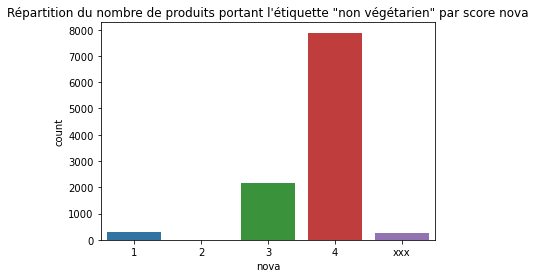

In [152]:
sns.countplot(data=data_nv,x='nova',order=['1','2','3','4','xxx'])
plt.title('Répartition du nombre de produits portant l\'étiquette "non végétarien" par score nova')
plt.show()

Les produits ayant l'étiquette "non végétarien" sont dans l'ensemble très transformés. 

### 3.10. Quels sont les 20 produits végétariens contenant le plus d'additifs? 

In [197]:
dt=data_v.sort_values(by=['nb_additifs'],ascending=False).head(20).loc[:,['nom','URL','nb_additifs']]
dt

,nom,URL,nb_additifs
63294,Skittles fruits - 191.4 g,https://fr.openfoodfacts.org//produit/4009900532839/skittles-fruits,15.0
59137,Cake gourmand citron - Monoprix Gourmet - 320 g,https://fr.openfoodfacts.org//produit/3350033231740/cake-gourmand-citron-monoprix-gourmet,15.0
74568,"Skittles Smoothies - Mars Wrigley Confectionery - 191,4 g",https://fr.openfoodfacts.org//produit/4009900531597/skittles-smoothies-mars-wrigley-confectionery,12.0
30428,Wraps - Goldähren - 372g,https://fr.openfoodfacts.org//produit/4061458045780/wraps-goldahren,12.0
36561,Cordon Bleu Végétale - Céréal - 200 g,https://fr.openfoodfacts.org//produit/3175681209831/cordon-bleu-vegetale-cereal,11.0
2456,Pringles Hot & Spicy - 175 g,https://fr.openfoodfacts.org//produit/5053990155941/pringles-hot-spicy,11.0
1818,Pain Complet 12 Céréales & Graines - bimbo - 680 g,https://fr.openfoodfacts.org//produit/8412600024485/pain-complet-12-cereales-graines-bimbo,11.0
72825,Go Ahead! Forest Fruit Yogurt Breaks 5 Packs of 2 Slices (178g) - 178 g (5 x 35.6 g),https://fr.openfoodfacts.org//produit/5000168181578/go-ahead-forest-fruit-yogurt-breaks-5-packs-...,11.0
68805,Mini cakes marbrés - Cereal,https://fr.openfoodfacts.org//produit/5410063023949/mini-cakes-marbres-cereal,11.0
52955,Sweet Strawberries - Look-O-Look - 115g,https://fr.openfoodfacts.org//produit/8713600175000/sweet-strawberries-look-o-look,10.0


# 4. Un modèle de machine learning pour prédire le nutriscore d'un produit.


Motivation : Nous avons remarqué qu'aucun produit végétarien n'a de nutriscore indiqué:

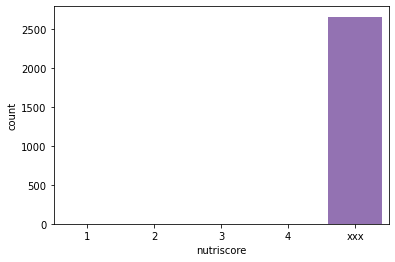

In [155]:
sns.countplot(data=data_v,x='nutriscore',order=['1','2','3','4','xxx'])
plt.show()

N'ayant pas trouvé de formule précise du nutriscore, nous décidons de faire un modèle de classification qui peut prédire le nutriscore d'un produit.

In [158]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'nom', 'URL', 'code bar', 'nutriscore',
       'nova', 'ecoscore', 'quantite', 'conditionnement', 'marques',
       'categorie', 'label,certifications,récompenses', 'origine',
       'lieu de fabrication', 'code de traçabilité',
       'lien vers la page du produit', 'magasins', 'pays de vente', 'additifs',
       'ingrédients issus de l'huile de palme', 'vitamines ajoutées',
       'minéraux ajoutés', 'matières grasses/lipides pour 100g',
       'acides gras saturés pour 100g', 'sucres pour 100g', 'sel pour 100g',
       'catégories aux repères nutritionels similaires',
       'énergie en kj pour 100g', 'énergie en kcal pour 100g',
       'libellés verts', 'libellés oranges', 'libellés rouges',
       'nb_pays_vente', 'nb_additifs', 'huile de palme', 'vegetarien',
       'vegetalien', 'nvegetarien', 'nvegetalien'],
      dtype='object')

In [159]:
# Nous sélectionnons les colonnes relatives aux valeurs nutritives complétées
d=data[(data['nova']!='xxx') & (data['nutriscore']!='xxx') &\
          (data['ecoscore']!="xxx") & (data['matières grasses/lipides pour 100g'].notnull())&\
      (data['acides gras saturés pour 100g'].notnull()) & (data["sucres pour 100g"].notnull()) & (data["sel pour 100g"].notnull())&\
       (data['énergie en kj pour 100g'].notnull()) & (data['énergie en kcal pour 100g'].notnull())]

In [162]:
d=d.loc[:,['nova',"nutriscore",'ecoscore','matières grasses/lipides pour 100g','acides gras saturés pour 100g',\
          "sucres pour 100g","sel pour 100g","énergie en kj pour 100g","énergie en kcal pour 100g"]]

In [163]:
d.shape

(13250, 9)

Quelques nuages de points pour observer la répartion: 

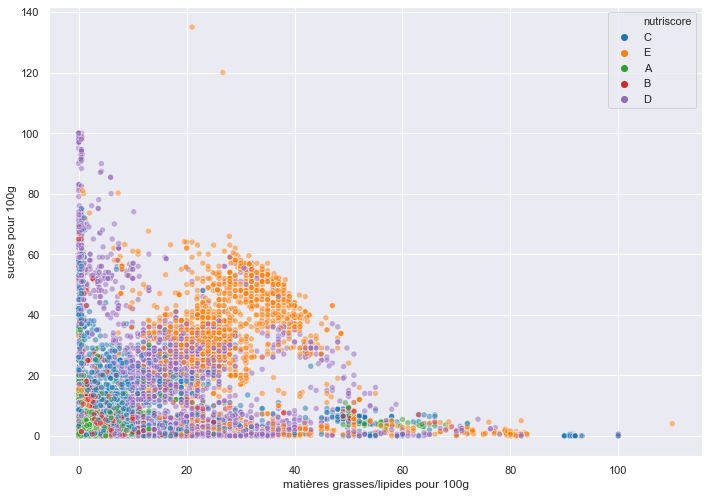

In [193]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=d,x='matières grasses/lipides pour 100g',y='sucres pour 100g',hue='nutriscore',alpha=0.5,palette='tab10')
plt.show()

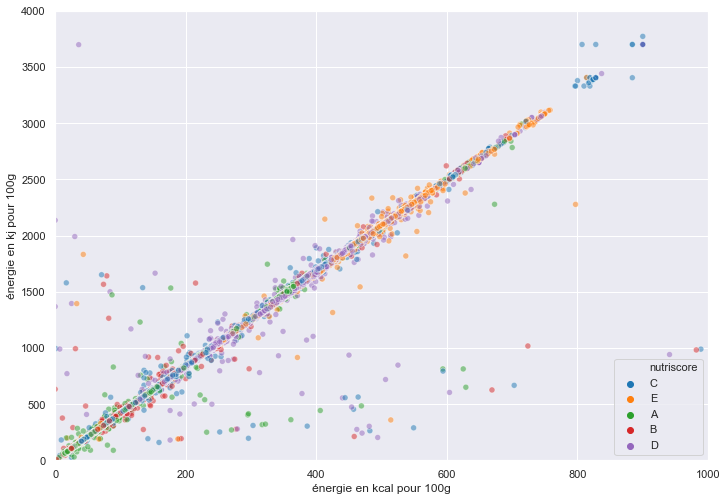

In [205]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=d,x='énergie en kcal pour 100g',y='énergie en kj pour 100g',hue='nutriscore',alpha=0.5,palette='tab10')
plt.xlim(0,1000)
plt.ylim(0,4000)
plt.show()

remarque : présence d'outliers qui ne respectent pas la conversion kj à kcal.

Modèle 

In [164]:
#standardization des variables numériques
data1=d.select_dtypes(include=['float64'])

In [165]:
data1

,matières grasses/lipides pour 100g,acides gras saturés pour 100g,sucres pour 100g,sel pour 100g,énergie en kj pour 100g,énergie en kcal pour 100g
2,1.5,0.3,15.0,1.00,1588.0,375.0
7,0.0,0.0,8.2,0.00,147.0,34.0
10,0.2,0.1,3.9,0.09,244.0,57.0
11,1.8,0.6,11.0,0.90,1557.0,368.0
14,12.0,7.5,23.0,1.39,1832.0,43.0
...,...,...,...,...,...,...
79978,8.0,5.0,17.0,0.08,723.0,172.0
79991,92.0,13.0,0.0,0.00,3404.0,828.0
79993,0.5,0.1,11.0,0.01,258.0,61.0
79994,0.8,0.5,10.5,0.12,276.0,65.0


In [166]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
data1_std = pd.DataFrame(std_scaler.fit_transform(data1), columns=data1.columns)

data1_std

,matières grasses/lipides pour 100g,acides gras saturés pour 100g,sucres pour 100g,sel pour 100g,énergie en kj pour 100g,énergie en kcal pour 100g
0,-0.744187,-0.643495,0.162986,0.114829,0.521550,0.478849
1,-0.827523,-0.678976,-0.229512,-0.685297,-1.300223,-1.287392
2,-0.816412,-0.667149,-0.477709,-0.613286,-1.177592,-1.168262
3,-0.727520,-0.608014,-0.067895,0.034817,0.482358,0.442592
4,-0.160836,0.208044,0.624749,0.426879,0.830025,-1.240776
...,...,...,...,...,...,...
13245,-0.383065,-0.087629,0.278427,-0.621287,-0.572020,-0.572608
13246,4.283746,0.858525,-0.702818,-0.685297,2.817413,2.825206
13247,-0.799744,-0.667149,-0.067895,-0.677296,-1.159892,-1.147543
13248,-0.783077,-0.619841,-0.096755,-0.589282,-1.137136,-1.126825


In [167]:
#traitement des variables catégorielles

data2=d.select_dtypes(include=['object'])

In [168]:
data2.head()

,nova,nutriscore,ecoscore
2,4,C,C
7,4,E,C
10,3,A,D
11,4,A,B
14,4,E,C


In [169]:
dummy=pd.get_dummies(data2)

In [170]:
df=pd.concat([dummy,data1],axis=1) 

In [171]:
X= df.to_numpy()                                    #X ensemble des variables prédictives
y_text = d['nutriscore'].to_numpy()   #y variable à prédire

In [172]:
X.shape

(13250, 20)

In [173]:
y_text.shape

(13250,)

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


In [199]:
y = LabelEncoder().fit_transform(y_text)  


In [200]:
d['nutriscore'].value_counts()

D    3724
C    2815
A    2755
E    2081
B    1875
Name: nutriscore, dtype: int64

In [201]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2,random_state=0)

In [221]:
#On va réalise un random forest
#choix de max_depth
from sklearn.model_selection import cross_val_score
valscore=[]
for k in range(1,10):
    clf=RandomForestClassifier(max_depth=k,n_estimators=30)   
    score=cross_val_score(clf , X_train, y_train, cv = 5,scoring='accuracy').mean()
    print(k,' ',score)
    valscore.append(score)

1   0.9288679245283019
2   0.9941509433962263
3   1.0
4   1.0
5   1.0
6   1.0
7   1.0
8   1.0
9   1.0


In [222]:
rnd_clf=knn=RandomForestClassifier(max_depth=3,n_estimators=30)

In [223]:
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=30)

In [227]:
yhat_train=rnd_clf.predict(X_train)

In [228]:
accuracy_score(yhat_train,y_train)

1.0

In [229]:
yhat_test=rnd_clf.predict(X_test)

In [230]:
accuracy_score(yhat_test,y_test)

1.0

On a obtenu une prédiction avec une accuracy de 100 % sur le jeu de test. 